# 分析哪些是BP+OSD/EPMLD/采样解码的解码对比

### 概率分布

In [1]:
from epmld.benchmark import generate_qldpc_detector_error_model, generate_qldpc_syndrome_and_observables
import cudf
import numpy as np
nkd = [72, 12, 6]
# nkd = [90, 8, 10]
# nkd = [144, 12, 12]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 10

related_path = "/home/normaluser/ck/epmld/data/external/epmld_experiment_data/epmld_paper_experiment/overall_performance/qldpc_code"

# related_path = "/home/normaluser/ck/epmld/data/external/epmld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, 
                                          related_path=related_path,have_stabilizer=False)

syndromes, actual_observables = generate_qldpc_syndrome_and_observables(nkd, r, p, noise_model, error_type, related_path,have_stabilizer = False)

### 分布的分析

In [2]:
sample = np.hstack((syndromes, actual_observables))
len_syndrome = syndromes.shape[1]
# 尝试使用 cudf 进行处理
df = cudf.DataFrame(sample)
unique_counts = df.value_counts().reset_index()

In [3]:
# 计算每个syndrome中True的数量
true_counts = unique_counts.iloc[:, :len_syndrome].sum(axis=1)

# 将结果添加到DataFrame中
unique_counts['true_count'] = true_counts

# 按true_count分组统计
grouped_counts = unique_counts.groupby('true_count').sum()

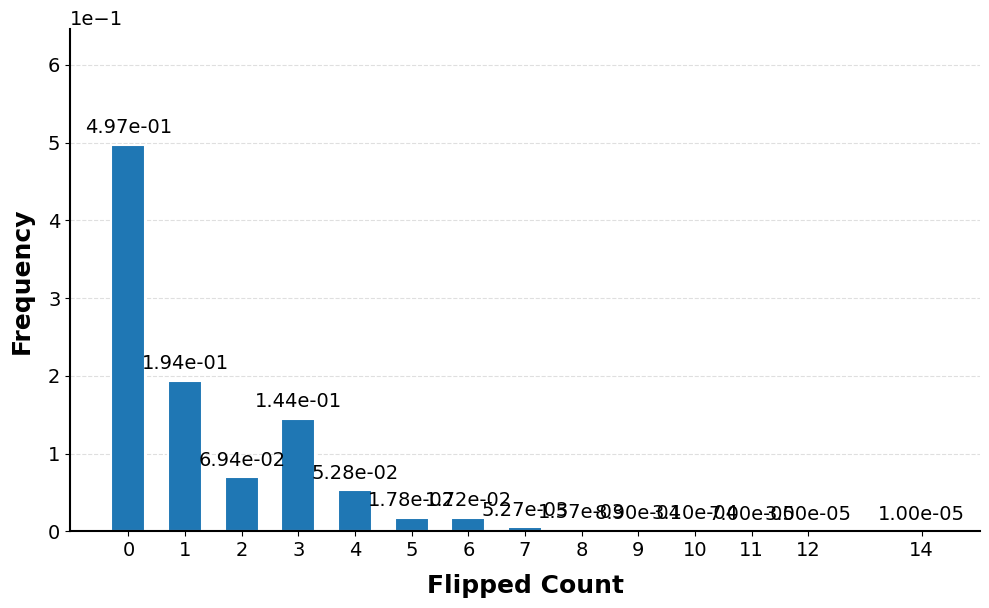

In [4]:
import matplotlib.pyplot as plt

true_counts = grouped_counts.index.values.get()
count_values = grouped_counts.iloc[:, -1].values.get()  # 假设counts在第一列

# 计算频率
total = count_values.sum()
frequency_values = count_values / total

# 创建图形（调整宽高比为黄金比例）
plt.figure(figsize=(10, 6.18))  # 黄金比例更美观
ax = plt.gca()

# 使用学术期刊推荐的配色（Nature风格）
bar_color = '#1f77b4'  # 标准学术蓝
edge_color = 'white'   # 白色边框

# 绘制柱状图（调整宽度和边框）
bars = ax.bar(true_counts, 
              frequency_values, 
              width=0.6,  # 更合理的宽度
              color=bar_color,
              edgecolor=edge_color,
              linewidth=1.5,
              zorder=2)  # 确保柱子显示在网格上方

# 添加数据标签（科学计数法显示）
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 
            height + 0.01,  # 稍微上移避免重叠
            f'{height:.2e}',  # 科学计数法2位小数
            ha='center', 
            va='bottom', 
            fontsize=14)

# 坐标轴设置
ax.set_xlabel('Flipped Count', 
              fontsize=18, 
              fontweight='bold',
              labelpad=10)
ax.set_ylabel('Frequency', 
              fontsize=18, 
              fontweight='bold',
              labelpad=10)

# 标题设置（去掉默认标题更学术）
# ax.set_title('Distribution of Syndrome by Flipped Count', 
#              fontsize=20, pad=20)

# 刻度设置
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(true_counts)  # 确保显示所有刻度
ax.set_xticklabels(true_counts, fontsize=14)

# y轴科学计数法显示
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(14)  # 科学计数法基数字体

# 网格和边框优化
ax.yaxis.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# 调整边距和范围
plt.tight_layout()
ax.set_ylim(0, max(frequency_values)*1.3)  # 为标签留空间

# # 保存矢量图（论文推荐格式）
# plt.savefig('flipped_count_distribution.pdf', 
#             bbox_inches='tight', 
#             dpi=300,
#             format='pdf')

plt.show()

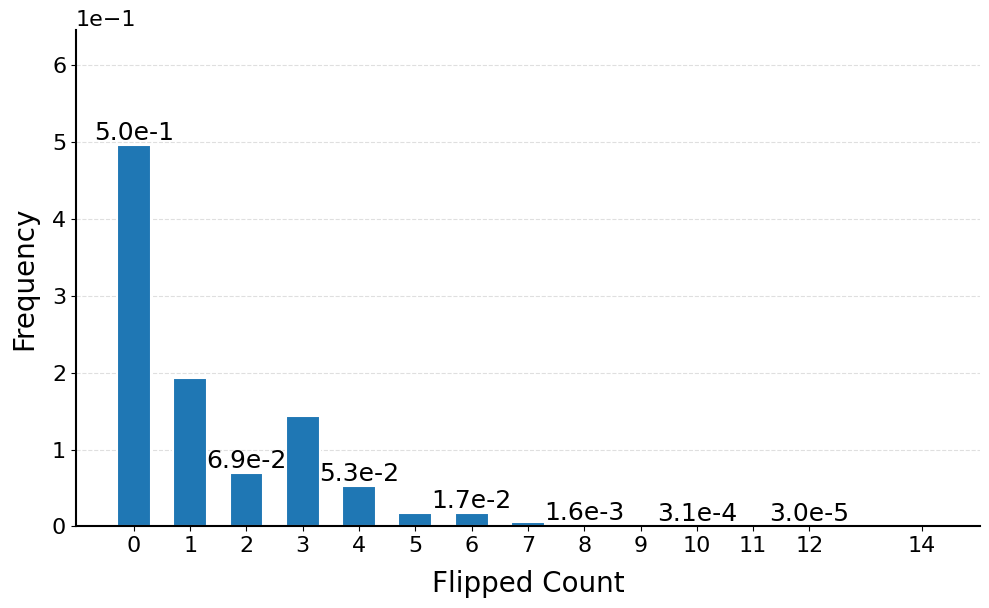

In [5]:
def custom_scientific_notation(num):
    """自定义科学计数法格式化函数，让指数部分以一位数字显示"""
    s = "{:.1e}".format(num)
    mantissa, exponent = s.split("e")
    exponent = int(exponent)
    if exponent < 0:
        return f"{mantissa}e-{abs(exponent)}"
    return f"{mantissa}e+{exponent}"

# 对true_counts排序并获取排序后的索引
sorted_indices = sorted(range(len(true_counts)), key=lambda i: true_counts[i])

# 根据排序后的索引重新排列true_counts和frequency_values
true_counts = [true_counts[i] for i in sorted_indices]
frequency_values = [frequency_values[i] for i in sorted_indices]

# plt.figure(figsize=(10, 6))
# bars = plt.bar(true_counts, frequency_values, width=0.5)  # 获取柱状图对象

# 创建图形（调整宽高比为黄金比例）
plt.figure(figsize=(10, 6.18))  # 黄金比例更美观
ax = plt.gca()

# 使用学术期刊推荐的配色（Nature风格）
bar_color = '#1f77b4'  # 标准学术蓝
edge_color = 'white'   # 白色边框
# edge_color = '#e0e0e0'

# 绘制柱状图（调整宽度和边框）
bars = ax.bar(true_counts, 
              frequency_values, 
              width=0.6,  # 更合理的宽度
              color=bar_color,
              edgecolor=edge_color,
              linewidth=1.5,
              zorder=2)  # 确保柱子显示在网格上方

for i, bar in enumerate(bars):
    if i % 2 == 0:  # 每隔一个显示值
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 custom_scientific_notation(height),  # 显示4位小数
                 ha='center', va='bottom', fontsize=18)  # 设置柱状图上文本的字体大小

# for i, bar in enumerate(bars):
#     # if i % 2 == 0:  # 每隔一个显示值
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2., height,
#                 custom_scientific_notation(height),  # 显示4位小数
#                 ha='center', va='bottom', fontsize=14)  # 设置柱状图上文本的字体大小
# # 添加标签和标题
# plt.xlabel('Flipped Count', fontsize=20)
# plt.ylabel('Frequency', fontsize=20)
# # plt.title('Distribution of Syndrome by Flipped Count (Normalized)', fontsize=24)
# plt.xticks(true_counts, fontsize=18)  # 确保x轴显示所有true_count值
# plt.yticks(fontsize=18)  # 设置y轴刻度的字体大小

# plt.tight_layout()
# 坐标轴设置
ax.set_xlabel('Flipped Count', 
              fontsize=20, 
            #   fontweight='bold',
              labelpad=10)
ax.set_ylabel('Frequency', 
              fontsize=20, 
            #   fontweight='bold',
              labelpad=10)

# 标题设置（去掉默认标题更学术）
# ax.set_title('Distribution of Syndrome by Flipped Count', 
#              fontsize=20, pad=20)

# 刻度设置
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(true_counts)  # 确保显示所有刻度
ax.set_xticklabels(true_counts, fontsize=16)

# y轴科学计数法显示
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)  # 科学计数法基数字体

# 网格和边框优化
ax.yaxis.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# 调整边距和范围
plt.tight_layout()
ax.set_ylim(0, max(frequency_values)*1.3)  # 为标签留空间

# 显示图形
# plt.show()

from pathlib import Path

# 保存图片为PDF
save_dir = Path("/home/normaluser/ck/epmld/experiment/epmld_paper_experiment/figure/introduction")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "distribution_of_syndrome.pdf"
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')

plt.show()



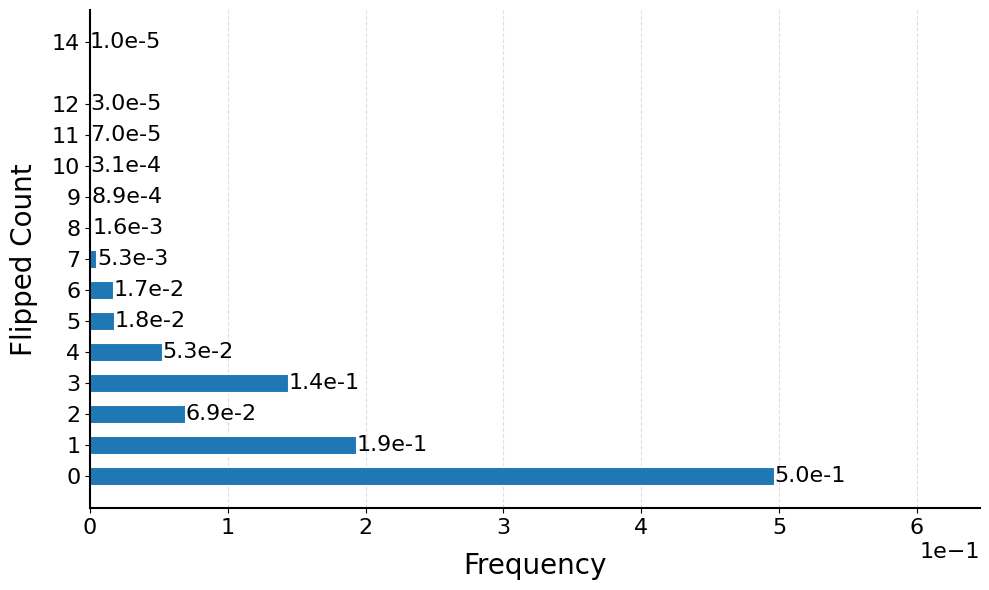

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path

def custom_scientific_notation(num):
    """自定义科学计数法格式化函数，让指数部分以一位数字显示"""
    s = "{:.1e}".format(num)
    mantissa, exponent = s.split("e")
    exponent = int(exponent)
    if exponent < 0:
        return f"{mantissa}e-{abs(exponent)}"
    return f"{mantissa}e+{exponent}"

# 对 true_counts 排序
sorted_indices = sorted(range(len(true_counts)), key=lambda i: true_counts[i], reverse=False)
true_counts = [true_counts[i] for i in sorted_indices]
frequency_values = [frequency_values[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))  # 黄金比例
ax = plt.gca()

# 配色
bar_color = '#1f77b4'
edge_color = 'white'

# 横向柱状图
bars = ax.barh(true_counts, frequency_values,
               height=0.6,
               color=bar_color,
               edgecolor=edge_color,
               linewidth=1.5,
               zorder=2)

# 添加标签（横向）
for i, bar in enumerate(bars):
    # if i % 2 == 0:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
                custom_scientific_notation(width),
                ha='left', va='center', fontsize=16)

# 坐标轴设置（注意x和y互换）
ax.set_ylabel('Flipped Count',
              fontsize=20,
            #   fontweight='bold',
              labelpad=10)
ax.set_xlabel('Frequency',
              fontsize=20,
            #   fontweight='bold',
              labelpad=10)

# 刻度设置
ax.set_yticks(true_counts)
ax.set_yticklabels(true_counts, fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)

# x轴科学计数法显示
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.xaxis.get_offset_text().set_fontsize(16)

# 网格和边框
ax.xaxis.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# 预留空间
ax.set_xlim(0, max(frequency_values) * 1.3)

plt.tight_layout()

# 保存
save_dir = Path("/home/normaluser/ck/epmld/experiment/epmld_paper_experiment/figure/introduction")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "distribution_of_syndrome_horizontal.pdf"
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')

plt.show()


取log看看


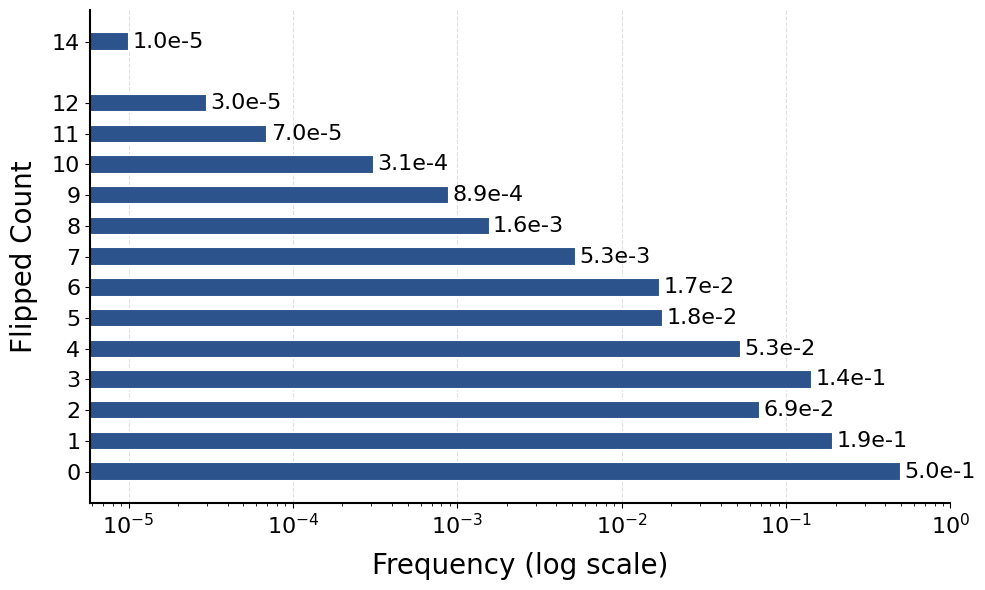

In [7]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def custom_scientific_notation(num):
    """自定义科学计数法格式化函数，让指数部分以一位数字显示"""
    s = "{:.1e}".format(num)
    mantissa, exponent = s.split("e")
    exponent = int(exponent)
    if exponent < 0:
        return f"{mantissa}e-{abs(exponent)}"
    return f"{mantissa}e+{exponent}"

# 对 true_counts 排序
sorted_indices = sorted(range(len(true_counts)), key=lambda i: true_counts[i], reverse=False)
true_counts = [true_counts[i] for i in sorted_indices]
frequency_values = [frequency_values[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
ax = plt.gca()

# 配色
# bar_color = '#1f77b4'
bar_color = "#2C538B"
edge_color = 'white'

# 横向柱状图
bars = ax.barh(true_counts, frequency_values,
               height=0.6,
               color=bar_color,
               edgecolor=edge_color,
               linewidth=1.5,
               zorder=2)

# 添加标签（横向）
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 0:
        plt.text(width * 1.05, bar.get_y() + bar.get_height()/2,
                 custom_scientific_notation(width),
                 ha='left', va='center', fontsize=16)

# 坐标轴设置
ax.set_ylabel('Flipped Count',
              fontsize=20,
              labelpad=10)
ax.set_xlabel('Frequency (log scale)',
              fontsize=20,
              labelpad=10)

# 刻度设置
ax.set_yticks(true_counts)
ax.set_yticklabels(true_counts, fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)

# 设置对数坐标轴
ax.set_xscale('log')

# 自定义刻度位置和标签
log_ticks = [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1.0]  # 10^{-5} 到 10^0
ax.set_xticks(log_ticks)
ax.set_xticklabels([r'$10^{{{}}}$'.format(i) for i in range(-5, 1)], fontsize=16)
# ax.set_xticklabels(log_ticks, fontsize=16)

# 设置 x 轴显示范围，防止 log(0) 错误
min_nonzero = min(f for f in frequency_values if f > 0)
# ax.set_xlim(min_nonzero / 2, max(frequency_values) * 1.3)

# 网格和边框
ax.xaxis.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()

# 保存
save_dir = Path("/home/normaluser/ck/epmld/experiment/epmld_paper_experiment/figure/introduction")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "distribution_of_syndrome_horizontal_logx.pdf"
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')

plt.show()


In [8]:
log_ticks

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]